# Reading pickle files

## Loading

In [1]:
import pickle

pickle_file_path = '../data/z-benchmark/battery_180.pickle'
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)
print('Loaded!')

Loaded!


In [2]:
for k, v in data.items():
    print(f'{k} ({v})' if len(str(v)) < 30 else f'{k} ({type(v)})')

numTrain (180)
numVal (180)
DSD (1500.0)
DSO (1000.0)
nDetector ([256, 256])
dDetector ([1.0, 1.0])
nVoxel ([256, 256, 256])
dVoxel ([1.0, 1.0, 1.0])
offOrigin ([0, 0, 0])
offDetector ([0, 0])
accuracy (0.5)
mode (parallel)
filter (None)
totalAngle (179)
startAngle (0)
randomAngle (False)
convert (True)
rescale_slope (1.0)
rescale_intercept (0.0)
normalize (True)
noise (0)
image (<class 'numpy.ndarray'>)
train (<class 'dict'>)
val (<class 'dict'>)


In [3]:
data['image'].shape

(256, 256, 256)

## Inspecting the train & val set

In [4]:
train_projections = data["train"]["projections"]
val_projections = data["val"]["projections"]

In [5]:
data["train"].keys()

dict_keys(['angles', 'projections'])

In [6]:
data["train"]["angles"].shape

(180,)

In [7]:
train_projections.shape, train_projections.dtype

((180, 256, 256), dtype('float32'))

Global statistics

In [8]:
import numpy as np

global_mean = np.mean(train_projections)
global_std = np.std(train_projections)
global_median = np.median(train_projections)
print(f"Global Mean: {global_mean},\nGlobal Std: {global_std},\nGlobal Median: {global_median}")


Global Mean: 0.04711303859949112,
Global Std: 0.007384229451417923,
Global Median: 0.04721568897366524


Resize to 256x256.

In [9]:
import cv2
import numpy as np

def resize_projections_cv2(projections, new_size=(256, 256)):
    """
    Resizes a 3D stack of projections using OpenCV.

    :param projections: NumPy array of shape (50, 512, 512)
    :param new_size: Tuple (new_H, new_W), default is (256, 256)
    :return: Resized projections of shape (50, 256, 256)
    """
    resized_projections = np.array([cv2.resize(proj, new_size, interpolation=cv2.INTER_LINEAR) for proj in projections])
    return resized_projections

In [10]:
train_projections = resize_projections_cv2(train_projections)
val_projections = resize_projections_cv2(val_projections)

print("Train projections shape:", train_projections.shape)  # (50, 256, 256)
print("Val projections shape:", val_projections.shape)  # (50, 256, 256)

Train projections shape: (50, 256, 256)
Val projections shape: (50, 256, 256)


In [11]:
print('before', data['nDetector'])
data['nDetector'] = [512, 512]
print('after', data['nDetector'])

before [256, 256]
after [512, 512]


Per-projection statistics

In [9]:
import matplotlib.pyplot as plt

def plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Statistics per Projection'):
    plt.figure(figsize=(8, 4))
    plt.plot(means_per_projection, label='Mean', color='blue', marker='o')
    plt.plot(mins_per_projection, label='Min', color='red', marker='x')
    plt.plot(maxs_per_projection, label='Max', color='green', marker='s')

    plt.xlabel('Projection Index')
    plt.ylabel('Pixel Intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.show()

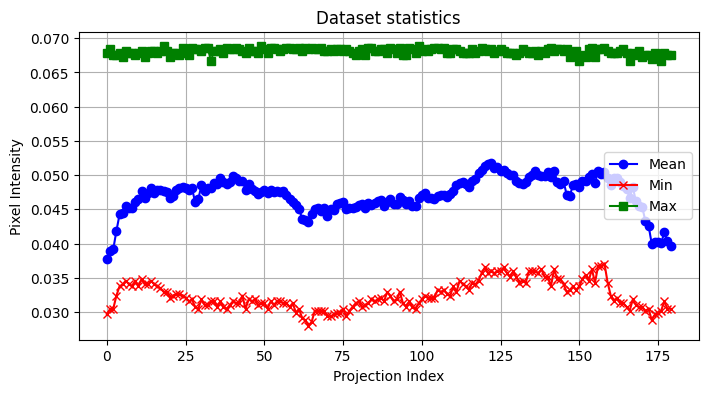

In [10]:
means_per_projection = np.mean(train_projections, axis=(1, 2))
mins_per_projection = np.min(train_projections, axis=(1, 2))
maxs_per_projection = np.max(train_projections, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Dataset statistics')

In [162]:
train_projections.shape

(50, 512, 512)

We normalize the projections and see what happens.

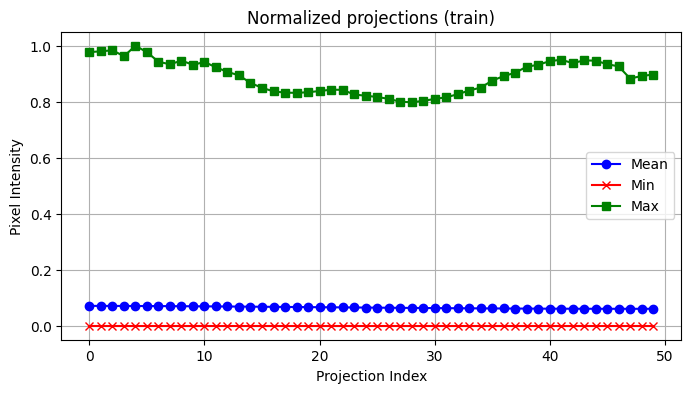

In [163]:
min_val = np.min(train_projections)
max_val = np.max(train_projections)
train_projections_norm = (train_projections - min_val) / (max_val - min_val)

means_per_projection = np.mean(train_projections_norm, axis=(1, 2))
mins_per_projection = np.min(train_projections_norm, axis=(1, 2))
maxs_per_projection = np.max(train_projections_norm, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Normalized projections (train)')

Normalized also the projections in the validation set.

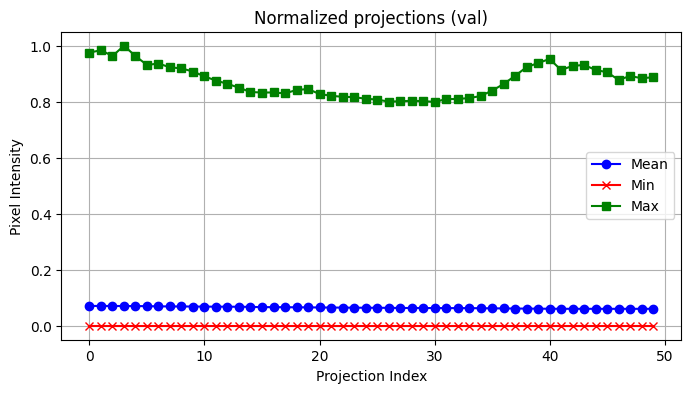

In [164]:
min_val = np.min(val_projections)
max_val = np.max(val_projections)
val_projections_norm = (val_projections - min_val) / (max_val - min_val)

means_per_projection = np.mean(val_projections_norm, axis=(1, 2))
mins_per_projection = np.min(val_projections_norm, axis=(1, 2))
maxs_per_projection = np.max(val_projections_norm, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Normalized projections (val)')

Save pickle file with normalized projections.

In [165]:
data["train"]["projections"] = train_projections_norm
data["val"]["projections"] = val_projections_norm

pickle_file = "../data/z-benchmark/bonsai_50_norm.pickle"
with open(pickle_file, "wb") as f:
    pickle.dump(data, f)

print(f'Saved!')

Saved!


In [166]:
train_projections_norm.min(), train_projections_norm.max()

(0.0, 1.0)

In [167]:
val_projections_norm.min(), val_projections_norm.max()

(0.0, 1.0)

Save and that's it.

Histogram of pixel intensities

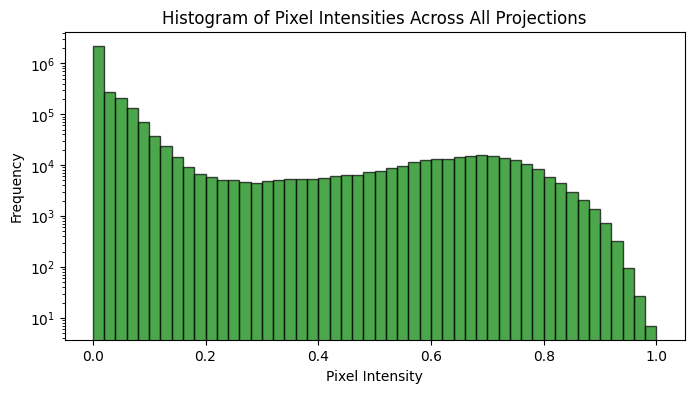

In [149]:
plt.figure(figsize=(8, 4))
plt.hist(train_projections_norm.ravel(), bins=50, color='green', alpha=0.7, edgecolor='black', log=True)
plt.title("Histogram of Pixel Intensities Across All Projections")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

Display sample projections

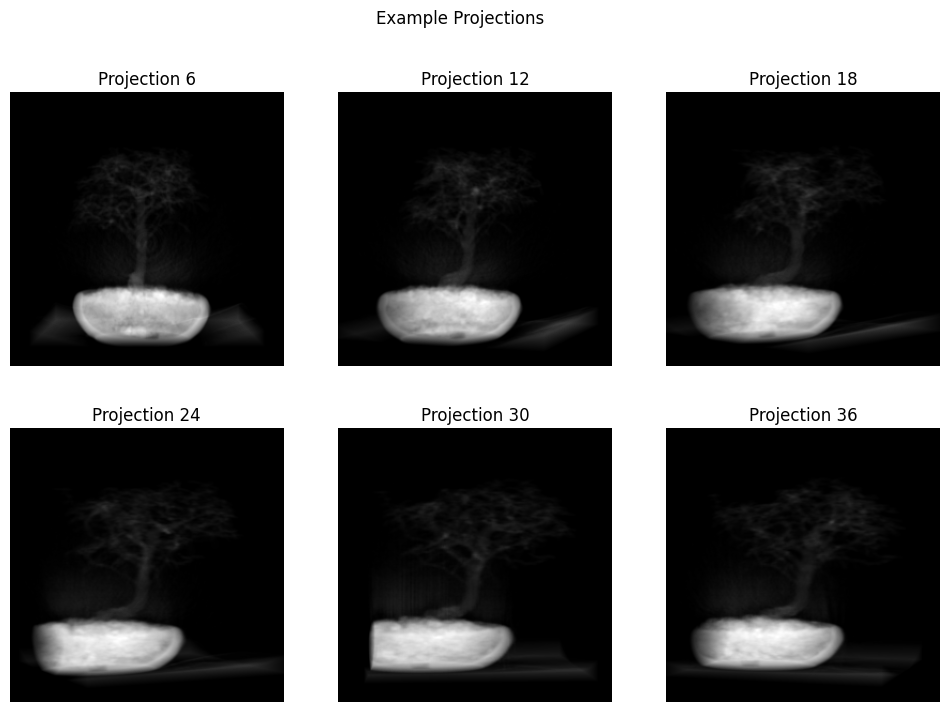

In [150]:
skip_every = 6

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_projections_norm[skip_every * i], cmap='gray')
    plt.title(f"Projection {skip_every * (i+1)}")
    plt.axis('off')
plt.suptitle("Example Projections")
plt.show()


## Inspecting the GT volume

In [151]:
data['image'].shape

(256, 256, 256)

In [13]:
gt_volume = data['image']
np.save('../data/z-bin/bonsai_gt.npy', gt_volume)

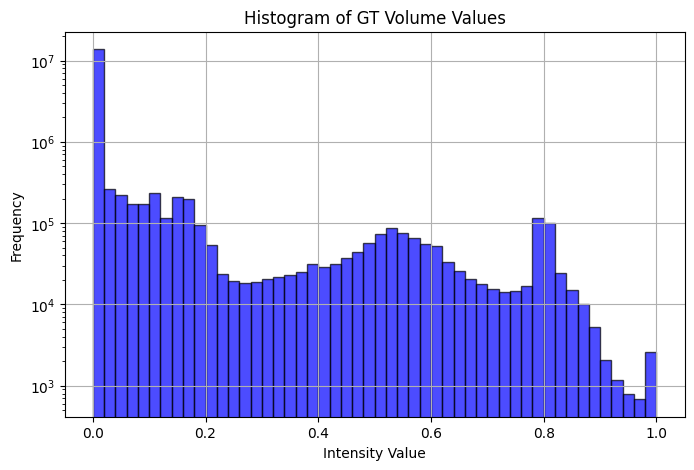

In [16]:
import matplotlib.pyplot as plt

def plot_histogram(gt_volume, bins=50, log=False):
    """
    Plots the histogram of values in a 3D ground truth volume.

    :param gt_volume: NumPy array of shape (D, H, W)
    :param bins: Number of histogram bins (default: 50)
    """
    flattened_values = gt_volume.flatten()  # Convert 3D data to 1D
    plt.figure(figsize=(8, 5))
    plt.hist(flattened_values, bins=bins, color='blue', alpha=0.7, edgecolor='black', log=log)
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of GT Volume Values")
    plt.grid(True)
    plt.show()

plot_histogram(gt_volume, log=True)

In [15]:
gt_volume.min(), gt_volume.max()

(0.0, 1.0)